# Analyzing Global Sea Level in GFDL Ocean Models

<i>John Krasting, Jacob Steinberg, on behalf of the GFDL Oceans and Cryosphere Division</i>

In this notebook, we will conduct a simple analysis of global sea level to demonstrate the capabilities of GFDL's models and the domain knowledge needed to interpret the modeling products.

### Contemporary Sea Level Budget

Observed global sea level is rise is dominated by two main factors:

<img src="https://www.ipcc.ch/report/ar6/wg1/downloads/figures/IPCC_AR6_WGI_CCBox_9_1_Figure_1.png">

* Ocean warming and thermal expansion
* Ice Sheet melt contributions

### Processes Driving Sea Level Change

In addition to these two primary drivers, other factors influence sea level at the regional and local levels.

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*UYQ1hzn-1cBp_3NYlQir6A.png">

Some of these features are represented in GFDL's ocean and climate models:
* Ocean warming
* Ocean circulation changes
* Hydrological changes (precipatation, evaporation, runoff)
* Atmospheric phenomenon (winds, storms)

Others are areas of active development
* Coupled interactive ice sheet models
* Land processes (salt intrusion, innundation, groundwater extraction)

<i>To date, no global climate model represents all of the drivers of sea level change.</i>

### Accessing GFDL's Climate Model Output

GFDL participates in the Coupled Model Intercomparison Project (CMIP). This is one of the more visibile products GFDL contributes to scientific communitity, enabling fundamental and applied research of climate change and impacts as well as informing major synthesis reports, such as the IPCC and National Climate Assessment.

GFDL had versions of the OM4 ocean model that participated in CMIP6:
* GFDL-CM4 (0.25-degree eddy-permitting horizontal resolution)
* GFDL-ESM4 (0.5-degree horizontal resolution)
* GFDL-SPEAR (1.0-degree horizontal resolution)

<i>Here, we will use results from the ESM4 model which provides a compromise between resolution and data volume</i>

We will also access GFDL's data through <a href="https://console.cloud.google.com/marketplace/product/noaa-public/cmip6">NOAA's Public Datasets on Google Cloud</a>  CMIP6 is organized through the World Climate Research Programme (WCRP) and the data on Google Cloud were processed and uploaded by the Pangeo Project.  (Similar data also exist on Amazon S3)

<img src="https://i.ytimg.com/vi/10rzdGCAIYY/mqdefault.jpg">

### Software Tools

This Jupyter notebook will use a number of Python-based analysis tools:
* Standard libraries (NumPy, Pandas, Matplotlib)
* xarray
* momlevel

The `momlevel` package is a collection of sea-level specific routines developed at GFDL to aid the analysis of MOM6 ocean model results <i>(Krasting et al., in revision)</i>  For more details, see https://momlevel.readthedocs.io/en/v0.0.7/objective.html

### Setup the Software Environment

In [ ]:
# Do this once!  After installing these tools, go to:
#    Runtime --> Restart Session

! pip  install momlevel intake intake-esm

In [1]:
# Load software packages
import xarray as xr
xr.set_options(display_style='html')

import pandas as pd
import numpy as np

import momlevel
import fsspec
import gcsfs
import intake
import nc_time_axis

import matplotlib.pyplot as plt
%matplotlib inline

### Load GFDL-ESM4 Sea-Surface Height (`zos`) Data from Google Cloud

In [2]:
# Load the cataolog of datasets on Google Cloud
cat_url = 'https://storage.googleapis.com/cmip6/pangeo-cmip6.json'
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [3]:
# Refine data to our requested list
datasets = col.search(
    experiment_id=['historical'],
    table_id=['Ofx','Omon'],
    variable_id=['areacello','zos'],
    grid_label='gn',
    member_id='r1i1p1f1',
    source_id="GFDL-ESM4"
)

df = datasets.df
df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726
1,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Omon,zos,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726


In [4]:
# Connect to Google Cloud
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')
zstores = df.zstore.values
mappers = [fs.get_mapper(x) for x in zstores]
ds = [xr.open_zarr(x, consolidated=True) for x in mappers]
ds = xr.merge(ds)

ds

<xarray.Dataset>
Dimensions:    (y: 576, x: 720, vertex: 4, bnds: 2, time: 1980)
Coordinates:
    lat        (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    lat_bnds   (y, x, vertex) float32 dask.array<chunksize=(576, 720, 4), meta=np.ndarray>
    lon        (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    lon_bnds   (y, x, vertex) float32 dask.array<chunksize=(576, 720, 4), meta=np.ndarray>
  * x          (x) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * y          (y) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * bnds       (bnds) float64 1.0 2.0
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: vertex
Data variables:
    areacello  (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    zos        (time, y, x) float32 dask.array<chunksize=(61, 576, 720), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    variable_id:            areacello
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/a988aa00-4496-4639-8a25-823cfc15c60b
    version_id:             v20190726

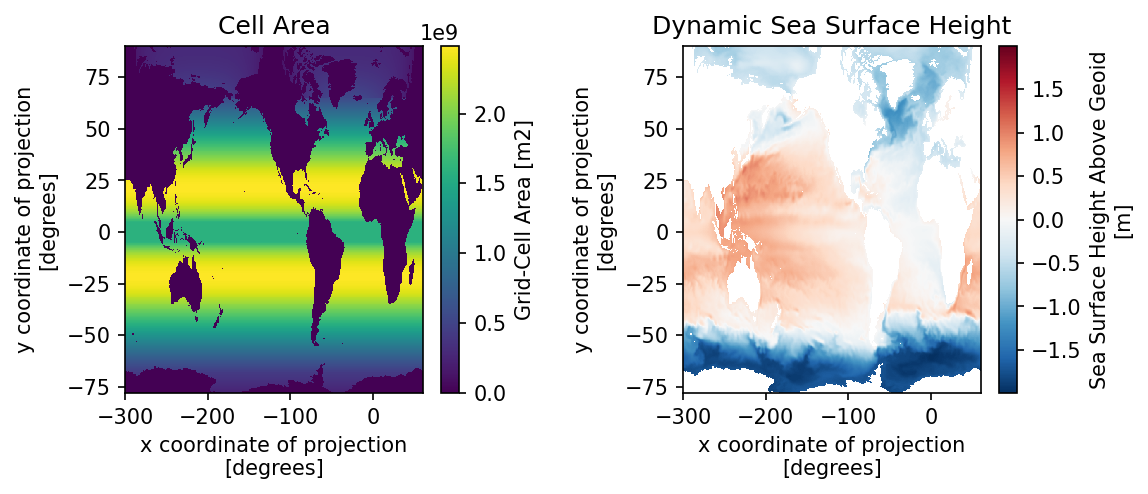

In [5]:
fig = plt.figure(figsize=(8,3), dpi=150)

ax1 = plt.subplot(1,2,1)
ds.areacello.plot(ax=ax1)
_ = ax1.set_title("Cell Area")

ax2 = plt.subplot(1,2,2)
ds.zos.isel(time=-1).plot(ax=ax2)
_ = ax2.set_title("Dynamic Sea Surface Height")

plt.subplots_adjust(wspace=0.5)

In [ ]:
ssh_global_monthly = ds.zos.weighted(ds.areacello).mean(("y","x")).load()
ssh_global_annual = momlevel.util.annual_average(ssh_global_monthly).load()

In [ ]:
fig = plt.figure(figsize=(8,4), dpi=150)
ax = plt.subplot(1,1,1)

ax.plot(ssh_global_monthly.time.values,ssh_global_monthly.values, linewidth=0.5, color="lightgray")
ax.plot(ssh_global_annual.time.values,ssh_global_annual.values, linewidth=1.2, color="red")

ax.set_title("Global Mean Dynamic Sea Surface Height")
ax.set_ylabel("m")

In [ ]:
datasets = col.search(
    experiment_id=['historical'],
    table_id=['Ofx','Omon'],
    variable_id=['volcello','thetao', 'so', 'areacello'],
    grid_label='gn',
    member_id='r1i1p1f1',
    source_id="GFDL-ESM4"
)

df = datasets.df


In [ ]:
df

In [ ]:
zstores = df.zstore.values
print(zstores)

fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# create a MutableMapping from a store URL
mappers = [fs.get_mapper(x) for x in zstores]

# make sure to specify that metadata is consolidated
ds = [xr.open_zarr(x, consolidated=True) for x in mappers]

ds = xr.merge(ds)

In [ ]:
ds["deptho"] = xr.open_zarr("https://extranet.gfdl.noaa.gov/~John.Krasting/models/GFDL-ESM4/deptho").deptho.load()

In [ ]:
ds

In [ ]:
steric = momlevel.steric(ds.isel(time=slice(-360,None)), domain="global", coord_names={"z":"lev"})

In [ ]:
steric_change = steric[0].steric.load()